In [1]:
import sys
sys.path.append('../')
from library.datasets import ProstateCancerDataset
from library.train import create_dataloader
from entrypoint import prostate_scoring_function
import matplotlib.pyplot as plt
import torch
from library.models import *
import random

In [2]:
prostate_dir = '../datasets/train_prostate/train/'
random_seed = 24042

In [3]:
val_dataset = ProstateCancerDataset(
                prostate_dir, split_type="val", random_seed=random_seed, input_slice_count=3,
            )

In [4]:
val_loader = create_dataloader(val_dataset, batch_size=3, shuffle=False)

In [5]:
test_dataset = ProstateCancerDataset(prostate_dir, split_type="test", random_seed=random_seed, input_slice_count=3)

In [6]:
test_loader = create_dataloader(test_dataset, batch_size=3, shuffle=False)

In [7]:
# fig, ax = plt.subplots(figsize = (21,14), nrows=2, ncols=3)

# ind = 0
# (val_image, _,_,_) = val_dataset[ind]
# (test_image, _,_,_) = test_dataset[ind]
# for k in range(3):
#     ax[0,k].imshow(val_image[k,:,:].numpy().squeeze())
#     ax[1,k].imshow(test_image[k,:,:].numpy().squeeze())

In [8]:
bad_model_acc = ('tuning_exp_training_details/combined_model_raw_metadata/ProstateCombinedModelV1_1Tiny/2023-11-28T02-12-53/'
'3_input_slices/0.01_starting_learning_rate/best_val_acc_ProstateCombinedModelV1_1Tiny.pt')
bad_model_score = ('tuning_exp_training_details/combined_model_raw_metadata/ProstateCombinedModelV1_1Tiny/2023-11-28T02-12-53/'
'3_input_slices/0.01_starting_learning_rate/best_val_score_ProstateCombinedModelV1_1Tiny.pt')
better_model_acc = ("tuning_exp_training_details/pretrained_model_raw_metadata/ProstateCombinedResnet18PretrainedModel/2023-11-27T22-30-46/"
                    "['layer1', 'layer2', 'layer3', 'layer4']_frozen/0.01_starting_learning_rate/best_val_acc_ProstateCombinedResnet18PretrainedModel.pt")
better_model_score = ("tuning_exp_training_details/pretrained_model_raw_metadata/ProstateCombinedResnet18PretrainedModel/2023-11-27T22-30-46/"
                    "['layer1', 'layer2', 'layer3', 'layer4']_frozen/0.01_starting_learning_rate/best_val_score_ProstateCombinedResnet18PretrainedModel.pt")
best_model_score = ("tuning_exp_training_details/pretrained_model_raw_metadata/ProstateCombinedResnet18PretrainedModel/2023-11-27T22-30-46/"
                    "[]_frozen/0.01_starting_learning_rate/best_val_score_ProstateCombinedResnet18PretrainedModel.pt")

shapes torch.Size([3, 3, 256, 256]) torch.Size([3, 2, 1]) tensor([[[76.0000],
         [13.6800]],

        [[58.0000],
         [ 3.9100]],

        [[68.0000],
         [ 9.6000]]])
3_input_slices_0.01_starting_learning_rate_best_val_score_ProstateCombinedModelV1_1Tiny.pt_results: 
	 val_results: 
		[[3.4477391242980957, 1.7627100944519043], [3.482805013656616, 1.7209590673446655], [3.4832234382629395, 1.7224496603012085]] - 
		[[0], [0], [0]] 
	 val_img_test_meta_results: 
		[[3.4144184589385986, 1.792975902557373], [3.482805013656616, 1.7209590673446655], [3.4832234382629395, 1.7224496603012085]] - 
		[[0], [0], [0]]
test_results: 
		[[3.8600871562957764, 1.877905249595642], [3.8700618743896484, 1.8760932683944702], [3.850447177886963, 1.8667705059051514]] - 
		[[0], [0], [0]]
test_img_val_meta: 
		[[3.869781494140625, 1.8780065774917603], [3.8700618743896484, 1.8760932683944702], [3.850447177886963, 1.8667705059051514]] - 
		[[0], [0], [0]]

['layer1', 'layer2', 'layer3', 'layer4'

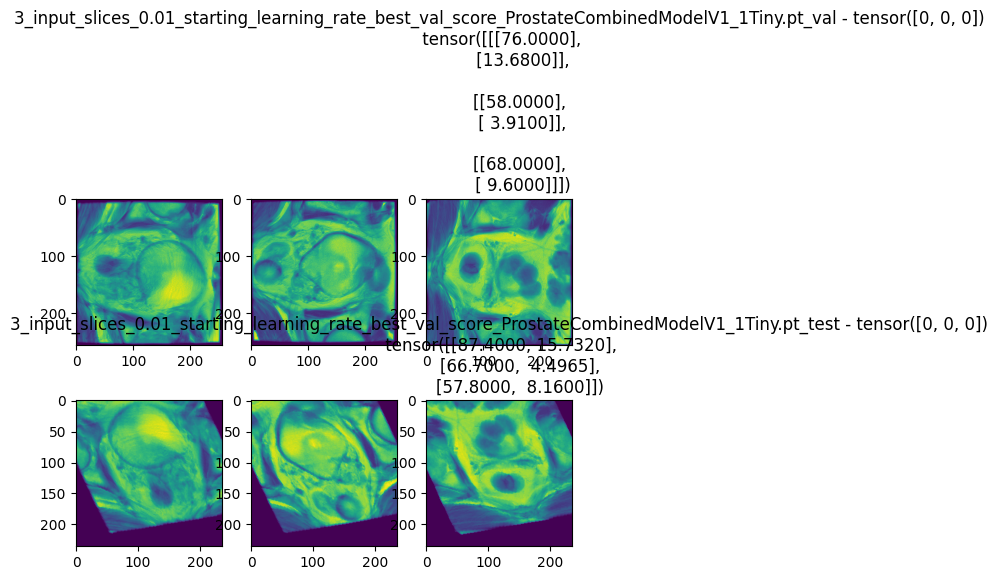

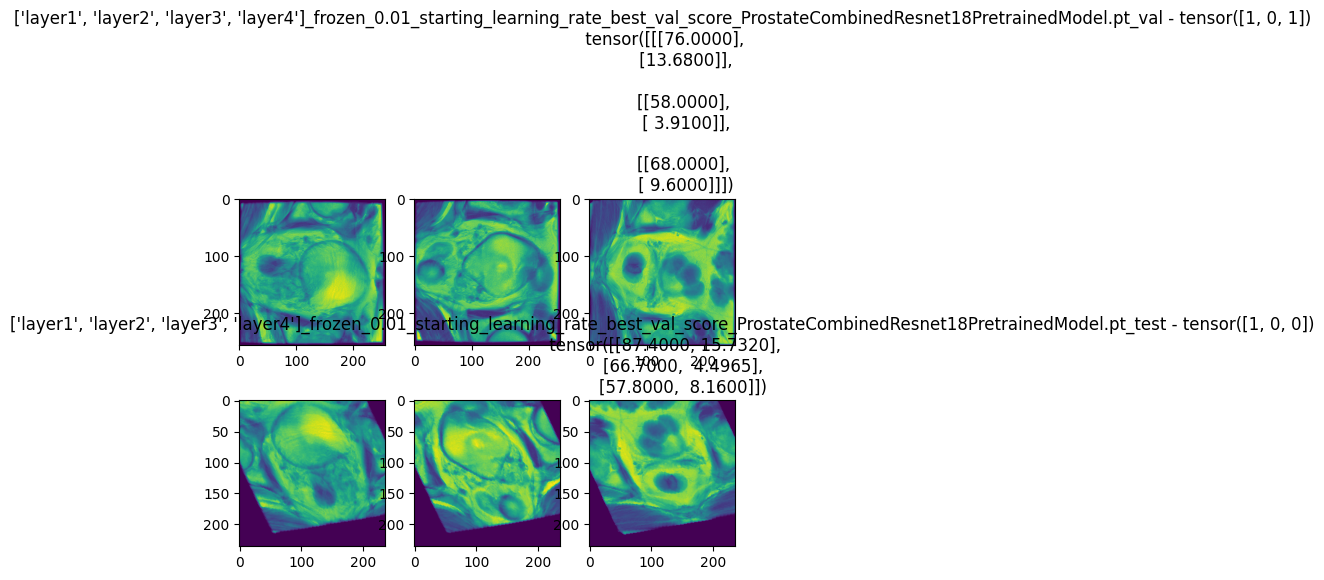

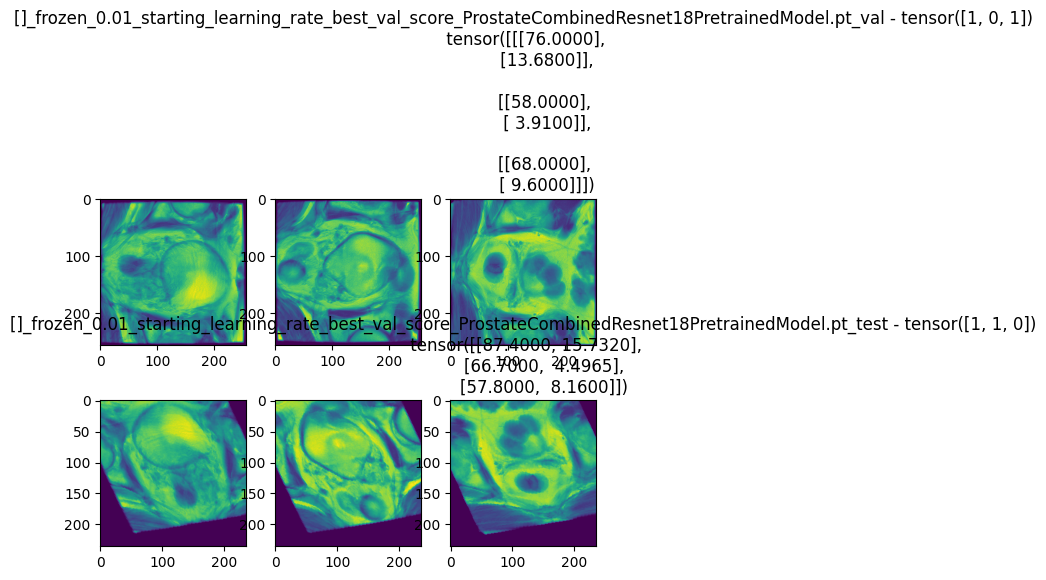

In [9]:
model_list = [
    # bad_model_acc, 
    bad_model_score, 
    # better_model_acc, 
    better_model_score,
    best_model_score,
]

### test metadata augmetation

model_path_to_model = {
    "ProstateCombinedResnet18PretrainedModel.pt": ProstateCombinedResnet18PretrainedModel(),
    "1Tiny.pt": ProstateCombinedModelV1_1Tiny(input_slice_count=3),   
}

ind = 1
random.seed(random_seed)

for batch_ind, (val_images, val_metadata, val_targets, case, t, q) in enumerate(val_loader):
    val_data = (val_images, val_metadata.squeeze())
    if 'case_0279' in case[0]: 
            break

for batch_ind, (test_images, test_metadata, test_targets, case, _, _) in enumerate(test_loader):
    test_metadata =test_metadata.squeeze()
    for k in range(val_images.shape[0]):
        scale_factor = random.choice([0.85, 1.15])
        test_metadata[k, 0] *= scale_factor
        test_metadata[k, 1] *= scale_factor
        test_data = (test_images, test_metadata)
    if 'case_0279' in case[0]: 
            break

print('shapes', val_images.shape, val_metadata.shape, val_metadata)
for model_path in model_list:
    model = model_path_to_model[model_path.split('_')[-1]]
    model_state_dict = torch.load(f"../{model_path}")
    model.load_state_dict(model_state_dict)
    model.eval()
    val_results = model(val_data)
    val_img_test_meta = model((val_data[0], test_data[1]))
    test_results = model(test_data)
    test_img_val_meta = model((test_data[0], val_data[1]))
    model_name = "_".join(model_path.split("/")[-3:])
    print(f"{model_name}_results: \n\t val_results: \n\t\t{val_results.detach().numpy().tolist()} - \n\t\t{val_results.argmax(dim=1, keepdim=True).detach().numpy().tolist()} \n\t "
          f"val_img_test_meta_results: \n\t\t{val_img_test_meta.detach().numpy().tolist()} - \n\t\t{val_img_test_meta.argmax(dim=1, keepdim=True).detach().numpy().tolist()}\n"
          f"test_results: \n\t\t{test_results.detach().numpy().tolist()} - \n\t\t{test_results.argmax(dim=1, keepdim=True).detach().numpy().tolist()}\n"
            f"test_img_val_meta: \n\t\t{test_img_val_meta.detach().numpy().tolist()} - \n\t\t{test_img_val_meta.argmax(dim=1, keepdim=True).detach().numpy().tolist()}\n")
    fig, ax = plt.subplots(nrows=2, ncols=val_images.shape[0])
    for k in range(val_images.shape[0]):
        img = val_images[k,0,:,:].numpy()
        ax[0,k].imshow(img)
    ax[0,k].set_title(f"{model_name}_val - {val_results.argmax(dim=1)}\n {val_metadata}")
    for k in range(test_images.shape[0]):
        img = test_images[k,0,:,:].numpy()
        ax[1,k].imshow(img)
    ax[1,k].set_title(f"{model_name}_test - {test_results.argmax(dim=1)}\n {test_metadata}")
print(val_targets.argmax(dim=1, keepdim=True))

In [10]:
case

[('case_0279', 'case_0121', 'case_0376'),
 {'image': tensor([[[[  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0],
            ...,
            [  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0]],
  
           [[  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0],
            ...,
            [  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0]],
  
           [[  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0],
            ...,
            [  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0]],
  
           ...,
  
           [[  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0],
            ...,
            [  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0]],
  
           [[  0,   0,   0],
            [  0,   0,   0],
            [  0,   0,   0],
            ...,
            [  0,   0,   0],
            [  0,

In [11]:
t['image'].shape

torch.Size([3, 256, 256, 3])